# Ambient Noise Signal Processing Detector
__Contributors:__ Bilguun Bulgan, Coraline Sun, Caitlyn Liu, Isaac Castillo
<br>__Instructors:__ Ryan Kastner, Perry Naughton 
<br>__Description:__ This project is a part of the UC San Diego Early Scholars Research Program (ERSP). This detector was built particularly to detect the signals of the snapping shrimp of the La Jolla shore waters. The detector takes in a sound file, calcuates the frequencies with the Fourier Transformation, then returns a "snap" as a unit. The snap should have comprehensive attributes of a sound wave, including the direct arrival of the snap, and its corresponding reflected waves. 
    

This is "Part 1" of our project, where we analyze data on primarly, single files.

In [2]:

import numpy as np

from scipy.io.wavfile import read
from scipy import signal, arange
from scipy.signal import hilbert, chirp

import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.axes as matax
import matplotlib.mlab as mlab
import matplotlib.patches as patches

First, we need to load the file, and gather all the necessary details. We are working primarily with a sampling frequency of 65501Hz, and a file of about 15-20 minutes. 

After loading the file, we want to setup some default variables that will help us operate on the data. 

In [134]:
sampFreq, sound = read('wav1.wav');

In [4]:
#taking 5 seconds of sample from 15s - 20sec in file 
#interval have 100 frames towards left and 400 frames towards right
initTime = 0;    # the start time
duration = 5;     # duration of time period start at initTime

'''
leftOffset = 100;  # how many frames we should expand the interval to the left
rightOffset = 200; # how many frames we should expand ther interval to the right
windowSize = 0.01; # the size of the window we will ignore after capture the frame above threshold
'''


'\nleftOffset = 100;  # how many frames we should expand the interval to the left\nrightOffset = 200; # how many frames we should expand ther interval to the right\nwindowSize = 0.01; # the size of the window we will ignore after capture the frame above threshold\n'

Our first task is to make a spectrogram of the sound data. A spectrogram is a graph which represents the presence of frequences in our sound files.

our function graphSpectrogram will take in some arguments: A sound snippet, a time-axis, and an axes to plot on. 
We will need a time array to represent the x-axis. Let's make a function to do that.

We also want to have a function that can take a snippet of our entire sound file. 


In [118]:
#start - the initial time(in seconds) of the sound snippet we want an x-axis of
#duration - the duration(in seconds) of the sound snippet
#samp - the sampling frequency of the sound file we are operating on. Default is sampFreq, our constant. 
def timeArray(start, duration, samp=sampFreq):
    start = samp * start;
    end = start + samp * duration;
    time = np.arange(0, end-start, 1)
    time = time

    return time/samp

#samp - the sampling frequency of the sound file we are operating on
#start - the initial time(in seconds) of the sound snippet we want an x-axis of
#duration - the duration(in seconds) of the sound snippet
def getSnippet(entire, start, duration, samp=sampFreq):
    start = samp * initTime;
    end = start + samp * duration;
    snip = entire[start:end];
    
    return snip

From these two functions, we can create a amplitude display of our data.

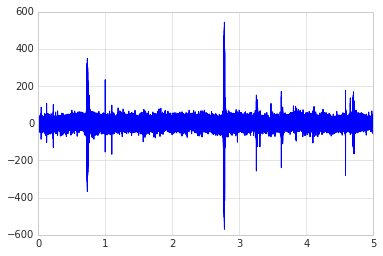

In [6]:
time = timeArray(initTime, duration)
snip = getSnippet(sound, initTime, duration)

plt.plot(time, snip)
plt.show();

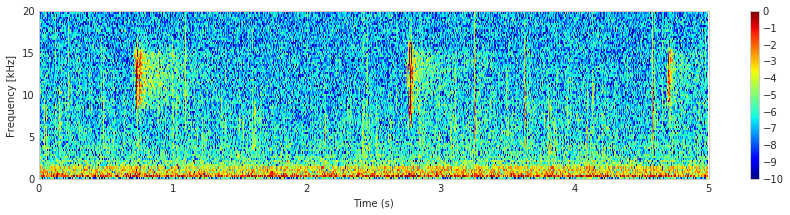

In [27]:
def graphSpectrogram(snip, time, ax=plt, snaps=None, pings=None, undef=None):
    fig = ax.figure(figsize=(15,3));
    f, t, Sxx = signal.spectrogram(snip, sampFreq, nperseg=256)
    im = ax.pcolormesh(t, f/1000, np.log(Sxx), cmap='jet')
    if(snaps != None):
        for i in snaps:
            ax.annotate("snap", xy=(i, 15), xytext=(i, 22), color='black', arrowprops=dict(facecolor='black', shrink=0.05))
    if(pings != None):
        for i in pings:
            ax.annotate("ping", xy=(i, 5), xytext=(i, -2), color='black', arrowprops=dict(facecolor='black', shrink=0.05))
    if(undef != None):
        for i in undef:
            ax.annotate("undefined", xy=(i, 4), xytext=(i, -3), color='black', arrowprops=dict(facecolor='black', shrink=0.05))
    im.set_clim(-10, 0)
    ax.ylim(0,20)
    cb = plt.colorbar(mappable = im)
    ax.ylabel('Frequency [kHz]')
    ax.ylim(0,20)
    ax.xlim(0, duration);
    ax.xlabel('Time (s)')
    ax.margins(x=0)
    im.set_clim(-10, 0)
    mappable = im


graphSpectrogram(snip,time)

We believe that the red areas are signals from floating buoyings, and the "long yellow" lines are snaps from shrimp.

Lets see if this is actually the case.

We want to identify the signals of the snaps, and the pings, through computer code!

To do this, we want to be able to identify a "signal". We consider a signal, any set of points over a certain amplitude.

In [8]:
windowSize = 0.1
def getSignals(snip, time, dev):
    thres = np.std(snip) * dev
    aboveThres = snip > thres 
    signals = []
    
    # current = the first time frame has amplitude above threshold
    # snaps = the time where each loud signal above threshold
    # snapIndex = the time frame indices of each loud signal above threshold
    current = time[aboveThres][0] 
    signals.append(int(current * sampFreq))

    # set a 0.01sec time window that slides across the current array
    # so that we only collect one time data for each loud signal
    for t in time[aboveThres]: 

        if (t > current + windowSize ):
            signals.append(int((t * sampFreq)))
            current = t
    return signals

In [9]:
signals = getSignals(snip, time, 6) #5 Deviations
print(signals)

[47571, 65318, 181044, 213188, 237600, 300361, 307942]


We got some signals, and we want to see what they look like. 

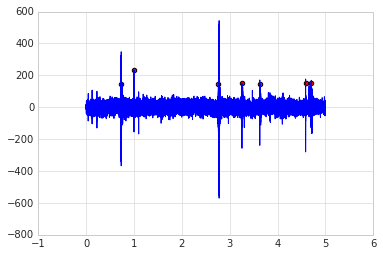

In [10]:
plt.scatter(time[signals], snip[signals], c='red')
plt.plot(time, snip)
plt.show();

The red dots represent signals. Clearly, they are above a certain threshold. Lets see what they look like up close. We expect "pings" to be longer, and "snaps" to be shorter. 

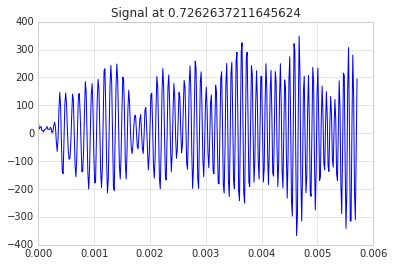

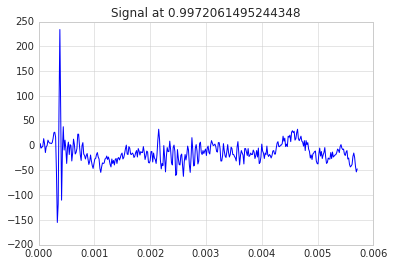

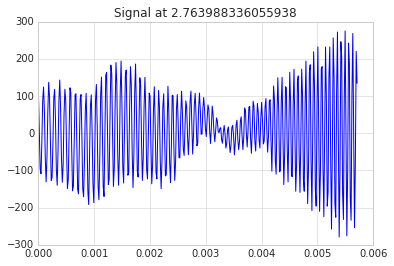

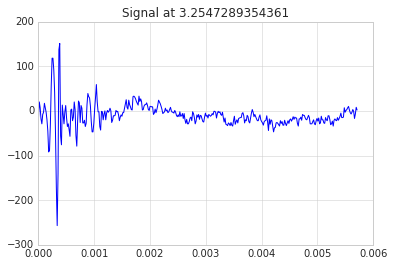

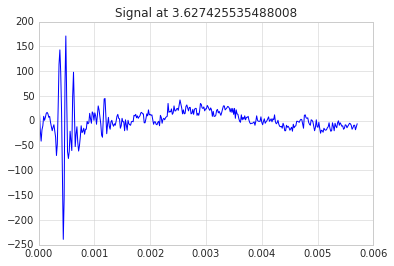

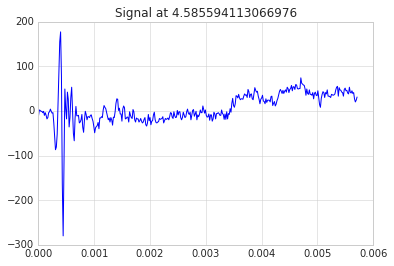

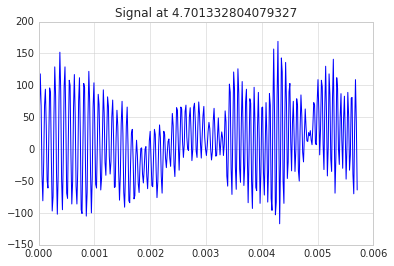

In [11]:
for i in signals:
  s = int(i-25)
  e = int(i+350)
  t = np.arange(0, e-s, 1)
  t = t / sampFreq
  mini = snip[s:e];
  plt.plot(t, mini)
  plt.title("Signal at " + str(i/sampFreq))
  plt.show()

Lets see where this corresponds on the spectrogram. First, lets attempt to classify them automatically.

To do this, we want to compare the ratio of frequencies present in the "mini snippet". 

In [30]:
def getFrequencies(signal):
    length = len(signal) # length of the signal
    #k = arange(length)
    #T = length/sampFreq
    #frq = k/T # two sides frequency range
    #frq = frq[range(np.int(length/2))] # one side frequency range

    frequencies = np.fft.fft(signal)/length # fft computing and normalization
    frequencies = frequencies[range(np.int(length/2))]
    
    return abs(frequencies)

def getRatio(signal):
    frequencies = getFrequencies(signal)
    ratio = sum(frequencies[34:68] * 100/sum(frequencies))
    return ratio;

def classify(signal):  
    ratio = getRatio(signal)
    if (ratio > 70):
        return "Ping"
    
    elif (ratio < 50):
        return "Snap"
    else:
        return "Undefined"
    
def plotFrequencies(signal, ax):
    length = len(signal) # length of the signal
    k = arange(length)
    T = length/sampFreq
    frq = k/T # two sides frequency range
    frq = frq[range(np.int(length/2))] # one side frequency range
 
    
    ax.plot(frq, getFrequencies(signal),'r') # plotting the spectrum

    ax.xlabel('Freq (Hz)')
    ax.ylabel('|Y(freq)|')
    ax.show();

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


65501


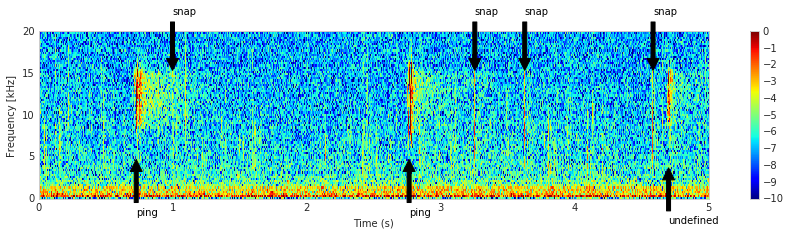

In [62]:
#This function gets the Pings and the Snaps
#signals - Array of indices at which a "signal" begins. 
#back - How far back to go, in milliseconds. 
#forward - How far forward to go in milliseconds.

#Sample: 20ms is about 1310 indicies
def getPingsAndSnaps(signals):
    snaps = []
    pings = []
    undef = []
    for i in signals:
      s = int(i-25)
      e = int(i+250)
      t = np.arange(0, e-s, 1)
      t = t / sampFreq
      mini = snip[s:e];
      #print(s, e, getRatio(mini))
      res = classify(mini)
    #  plt.plot(t, mini);
    #  plt.show();
    #  plotFrequencies(mini, plt);
      
      if(res == "Snap"):
        snaps.append(i/sampFreq)
      elif(res == "Ping"):
        pings.append(i/sampFreq)
      else:
        undef.append(i/sampFreq)

    return (pings, snaps, undef)
(pings, snaps, undef) = getPingsAndSnaps(signals)
graphSpectrogram(snip, time, pings=pings, snaps=snaps, undef=undef)


As we can see, we can are able to correctly identify the pings and snaps, correctly, for the most part. However, we cannot identify that final ping at the left. This is because it appears to overlap with a snap.

Now that we can correctly identify signals, we are interested in only using snaps in our research(for the most part).

Now, we are interested being able to see reflected waves, from the snap signals. By our previous method, we have the times of snaps, but we want actual signals. Where will these reflected waves even show up?

From a geometric analysis, we can see depending on how far a shrimp is from the recording auv, and how deep the ocean is, we will have a range to look at. The following code is not really parsable to the uninitiated, but its just essentially using similar triangles. In this assumption, we have that the waves reflect off the top and bottom surface smoothly using angles of reflections.

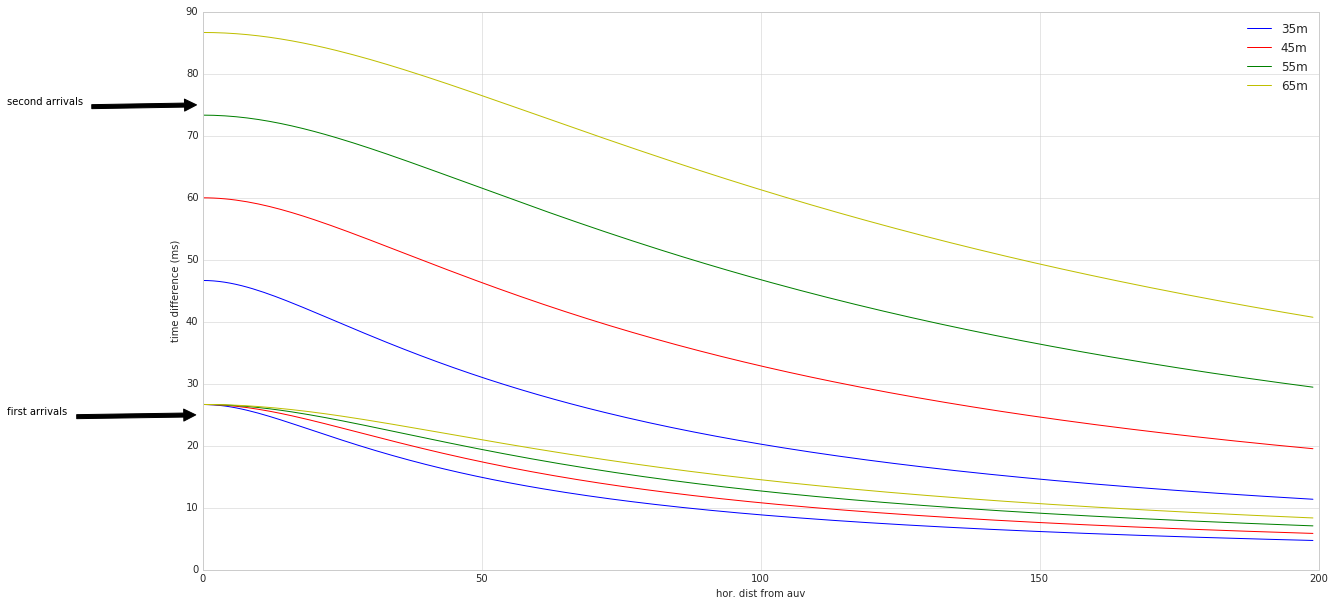

In [55]:
oceanDepth = 50
auvDepth = 20

def dirDist(x, auvDepth=auvDepth, oceanDepth=oceanDepth):
    return np.sqrt(x**2 + (oceanDepth - auvDepth) ** 2)

def refDist(x, auvDepth=auvDepth, oceanDepth=oceanDepth):
    return np.sqrt(oceanDepth**2  + ref1helper(x)**2) + np.sqrt(auvDepth**2 + (x-ref1helper(x))**2)
    
def ref1helper(x, auvDepth=auvDepth, oceanDepth=oceanDepth):
    return oceanDepth*x/(oceanDepth + auvDepth)

def ref2Dist(x, auvDepth=auvDepth, oceanDepth=oceanDepth):
    return 2 * np.sqrt(oceanDepth**2 + ref2helper(x)**2) + np.sqrt((oceanDepth-auvDepth)**2 + (x-2*ref2helper(x))**2)

def ref2helper(x, auvDepth=auvDepth, oceanDepth=oceanDepth):
    return oceanDepth*x/(3*oceanDepth-auvDepth)

def firTimeDist(x, auvDepth=auvDepth, oceanDepth=oceanDepth):
    return refDist(x, auvDepth, oceanDepth) - dirDist(x, auvDepth, oceanDepth)

def secTimeDist(x, auvDepth=auvDepth, oceanDepth=oceanDepth):
    return ref2Dist(x, auvDepth, oceanDepth) - dirDist(x, auvDepth, oceanDepth)

firstArrival = []
secondArrival = []
xdist = 200
plt.figure(figsize=(20,10))
color = ["b", "r", "g", "y"]
index=0
for j in range(35, 75, 10):
    for i in range(xdist):
        firstArrival.append(firTimeDist(i, 20, j)*2/3);
        secondArrival.append(secTimeDist(i, 20, j)*2/3);
    plt.plot(arange(xdist), firstArrival, c=color[index%4]);
    plt.plot(arange(xdist), secondArrival, label=str(j)+"m", c=color[index%4]);
    firstArrival = []
    secondArrival = []
    index = index+1;

plt.legend()
plt.annotate("first arrivals", xy=(0, 25), xytext=(-35, 25), color='black', arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate("second arrivals", xy=(0,75), xytext=(-35, 75), color='black', arrowprops=dict(facecolor='black', shrink=0.05))

plt.xlabel("hor. dist from auv");
plt.ylabel("time difference (ms)");
plt.show();

From this graph, its clear that as we vary the depth, and the horizontal distance from the AUV, the distance covers a lot time differences. Thus, if we claim to be able to identify a direct signal, we need to look in a lot of areas to identify its correct associating reflected signal. 

So, we if we are only interested in guaranteeing the presence of the first arrival in our scope, we need to have atleast a distance of 25 ms from the first arrival. This is about 1650 samples. But what is the first arrival? Are the pings we are picking up from our threshold detector first or second arrivals?

We can assume they are first arrivals, but maybe we can perform some analysis, later on.

If we lower the threshold, we can pick up more signals. Lets lower the threshold, and see the newly detected snaps. We assume that these may not be first arrivals, as their amplitudes aren't high enough.



In [83]:
def convertToIndices(times):
    indices = []
    for i in times:
        indices.append(int(i * sampFreq))
    return indices

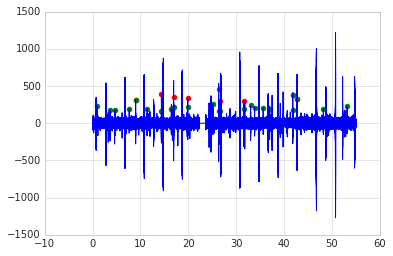

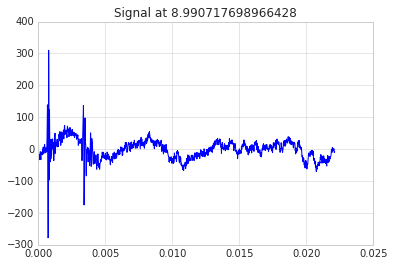

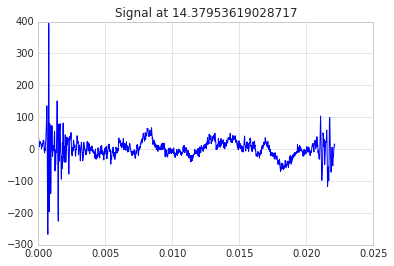

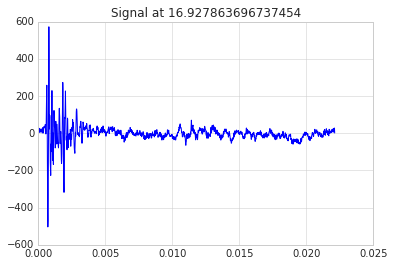

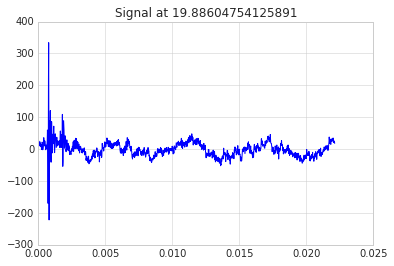

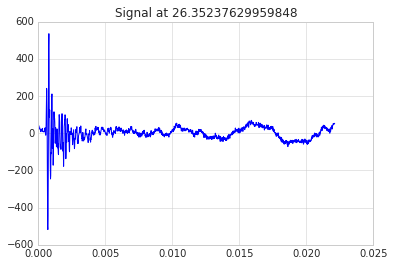

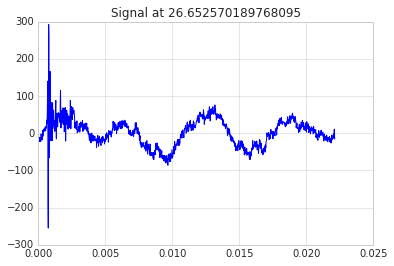

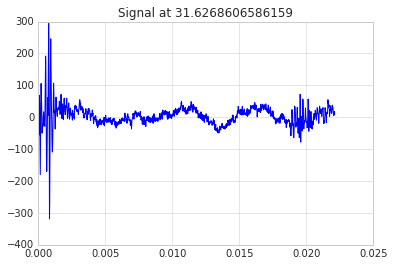

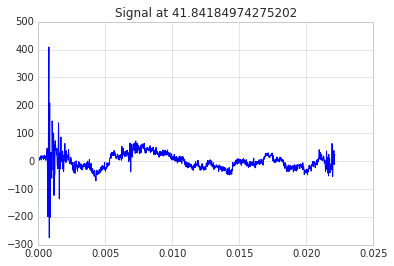

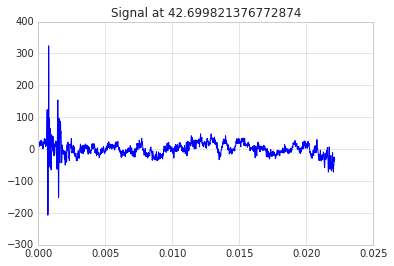

In [144]:
#We begin from 5 to 60 seconds.
time = timeArray(5, 55)
snip = getSnippet(sound, 5, 55)
top_signals = getSignals(snip, time, 10) #5 Deviations
btm_signals = getSignals(snip, time, 6)
#print(np.std(snip))
#print(top_signals)
(pings, top_snaps, undef) = getPingsAndSnaps(top_signals)
(pings, btm_snaps, undef) = getPingsAndSnaps(btm_signals)
top_snaps = convertToIndices(top_snaps);
btm_snaps = convertToIndices(btm_snaps);
#print(btm_signals)
#print(top_snaps)

plt.plot(time, snip)
plt.scatter(time[top_snaps], snip[top_snaps], color="r")
plt.scatter(time[btm_snaps], snip[btm_snaps], color="green")
plt.show();

for i in top_snaps:
  s = int(i-50)
  e = int(i+1400)
  t = np.arange(0, e-s, 1)
  t = t / sampFreq
  mini = snip[s:e];
  plt.plot(t, mini)
  plt.title("Signal at " + str(i/sampFreq))
  plt.show()

In [140]:
indices = convertToIndices(snaps)
print(indices)


[65318, 237607, 300362, 500029, 588901, 745751, 941873, 1077854, 1092235, 1108782, 1302555, 1645028, 1726096, 1742290, 2071576, 2163082, 2217841, 2337311, 2423711, 2740683, 2748995, 2796881, 3159497, 3484295]
